In [ ]:
!export PATH=/usr/local/cuda/bin:$PATH
!export CPATH=/usr/local/cuda/include:$CPATH
!export LD_LIBRARY_PATH=/usr/local/cuda/lib64:$LD_LIBRARY_PATH
!pip install --user torch==1.4.0+cu100 torchvision==0.5.0+cu100 -f https://download.pytorch.org/whl/torch_stable.html
!pip install --user torch-scatter==latest+cu100 torch-sparse==latest+cu100 -f https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.4.0.html
!pip install --user torch-cluster==1.5.4+cu100 torch-spline-conv==1.1.1 torch-geometric==1.4.2 -f https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.4.0.html
!pip install --user ipympl pyntcloud

# !curl -sL https://deb.nodesource.com/setup_13.x | sudo -E bash -
# !sudo apt-get install -y nodejs

# !pip install  --user ipywidgets
# !jupyter nbextension enable --py widgetsnbextension
# !sudo jupyter labextension install @jupyter-widgets/jupyterlab-manager

# Warning! Sometimes you have to use --no-cache-dir to avoid undefined symbol error

# Matplotlib
# !pip install —user ipympl

# !jupyter labextension install @jupyter-widgets/jupyterlab-manager
# !jupyter labextension install jupyter-matplotlib

In [ ]:
# insrtall openfoam
!sudo apt-get install -y openssh-client
!sudo apt-get install -y software-properties-common
!sudo sh -c "wget -O - https://dl.openfoam.org/gpg.key | apt-key add -"
!sudo add-apt-repository http://dl.openfoam.org/ubuntu
!sudo apt-get update
!sudo apt-get -y install openfoam5

!pip install --user numpy-stl
!echo "export PATH=/cvlabdata2/home/artem/autofoam/bin:$PATH" >> ~/.bashrc 
!echo ". /opt/openfoam5/etc/bashrc" >> ~/.bashrc 

In [ ]:
!sudo apt update
!sudo wget https://github.com/mmatl/travis_debs/raw/master/xenial/mesa_18.3.3-0.deb
!sudo dpkg -i ./mesa_18.3.3-0.deb || true
!sudo apt install -f
!git clone https://github.com/mmatl/pyopengl.git
!pip install --user ./pyopengl

!pip install --user pyrender
!pip3 install --user mesh-to-sdf
!export PYOPENGL_PLATFORM=osmesa

In [44]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import os
import sys
import time
import numpy as np
import json
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import (NNConv, GMMConv, GraphConv, Set2Set)
from torch_geometric.nn import (SplineConv, graclus, max_pool, max_pool_x, global_mean_pool)

#from neuralnet_pytorch.metrics import chamfer_loss

import trimesh

from visualization_utils import plot_mesh_3d

from models import *
from datasets import *
from visualization_utils import saveMeshPly
from sklearn.neighbors import KDTree

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[ 3.9247569e-02  3.1841435e-02  2.3998326e-02  1.6066901e-02
  8.1165498e-03 -1.0217540e-05 -7.7173021e-03 -1.5229406e-02
 -2.2645172e-02 -2.8789775e-02 -3.4031119e-02 -4.1592941e-02
 -5.0265651e-02 -6.0967192e-02 -7.5992599e-02 -9.3333140e-02
 -1.1487572e-01 -1.4251488e-01 -1.7777592e-01 -2.2102827e-01
 -2.7504367e-01 -3.0828968e-01 -3.4558356e-01 -3.8806203e-01
 -4.3862087e-01 -4.9601460e-01 -5.6028074e-01 -6.3776249e-01
 -7.2842467e-01 -8.3490551e-01]


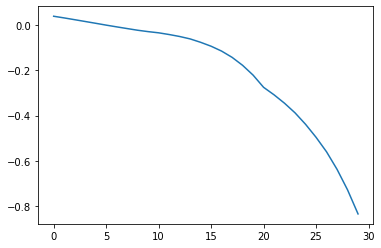

In [89]:
loss = np.load(
    '/cvlabdata2/home/artem/DeepSDF/Expirements/OptimizationPaper/SameLossSGD/FreeformFurrieDrag/20/loss_plot.npy')
print(loss)
plt.plot(loss)
plt.show()

## Copy optimized shapes

In [ ]:
idx=0
root = '/cvlabdata2/home/artem/DeepSDF/Expirements/OptimizationPaper/CleanedDataBadDrag/'
out_path = '/cvlabdata2/home/artem/DeepSDF/Expirements/Simulations/CleanedDataBadDrag/inputs/'
for name in filter(lambda x: x[0] != '.', os.listdir(root)):
    m = trimesh.load(os.path.join(root, name, str(idx), 'meshes/00029.ply'))\
               .export(os.path.join(out_path, name + '_' + str(idx) + '_input.stl'))

# Compute Statistics for Normalization

In [ ]:
objects = list()
for (dirpath, dirnames, filenames) in os.walk('/cvlabdata2/home/artem/Data/cars_remeshed_dsdf/outputs/'):
    objects += [os.path.join(dirpath, file) for file in filenames if file[-4:] == '.fld']

mean_values = np.zeros((len(objects), 4))
std_values = np.zeros((len(objects), 4))

for idx, fld_path in tqdm(enumerate(objects), total=len(objects)):
    fld = np.genfromtxt(fld_path, delimiter=',', skip_header=1)
    fld[fld > 10e5] = np.nan
    fld = fld[~np.isnan(fld).any(axis=1)]

    answers = fld[:, 3:]

    for f in range(answers.shape[1]):
        mean_values[idx, f] = np.mean(answers[:, f])
        std_values[idx, f] = np.std(answers[:, f])
        
print(np.mean(mean_values, axis=0))
print(np.mean(std_values, axis=0))

In [ ]:
!pwd

In [ ]:
objects = list()
for (dirpath, dirnames, filenames) in os.walk('/cvlabdata2/home/artem/Data/cars_remeshed_dsdf/outputs/fld'): #/cvlabdata2/home/artem/Data/cars_refined/simulated/scr
    objects += [os.path.join(dirpath, file) for file in filenames if file[-5:] == '.json' and file[0] != '.']

scr_data_store = np.zeros((len(objects), 12))

for idx, scr_path in tqdm(enumerate(objects), total=len(objects)):
    with open(scr_path) as scr_file:
        scr_data = json.load(scr_file)
        scr_data_store[idx, :3] = scr_data['pressure_drag']
        scr_data_store[idx, 3:6] = scr_data['viscous_drag']
        scr_data_store[idx, 6:9] = scr_data['pressure_moment']
        scr_data_store[idx, 9:] = scr_data['viscous_moment']  
        
print(np.mean(scr_data_store, axis=0))
print(np.std(scr_data_store, axis=0))

# Analyse the prediction of a trained Network

In [2]:
def getR2Score(y, pred):
    mean_data = np.mean(y.numpy())
    sstot = np.sum((y.numpy() - mean_data) ** 2)
    ssreg = np.sum((pred.numpy() - mean_data) ** 2)
    ssres = np.sum((pred.numpy() - y.numpy()) ** 2)
    return 1 - ssres / sstot

def getModelReport(model, data_path="/cvlabdata2/home/artem/Data/cars_remeshed_dsdf/outputs/fld", 
                   data_step=1, global_features=False, normalize=False):
    val_dataset = CDFDatasetInMemory(data_path, train=False)
    val_loader = torch_geometric.data.DataLoader(val_dataset, batch_size=1, shuffle=False)
    
    
    device = "cuda:0"
    model = model.to(device)
    model.eval()

    r2_scores = []
    pathes = []
    mses = []
    verticies = []
    for batch in tqdm(val_loader):
        batch = batch.to(device)
        with torch.no_grad():
            if global_features:
                local_preds, global_preds = model(batch.clone())
            else:
                local_preds = model(batch.clone())
    
        local_preds = local_preds.cpu().detach()
        data_instance = batch.y.cpu().detach()
        
        if normalize:
            local_preds = (local_preds - np.mean(local_preds[:, 0].numpy()) ) / np.std(local_preds[:, 0].numpy())
            data_instance = (data_instance - np.mean(data_instance[:, 0].numpy()) ) / np.std(data_instance[:, 0].numpy())
            
        r2_scores.append([getR2Score(data_instance[:, 0], local_preds[:, 0]),
                          getR2Score(data_instance[:, 1], local_preds[:, 1]),
                          getR2Score(data_instance[:, 2], local_preds[:, 2]),
                          getR2Score(data_instance[:, 3], local_preds[:, 3]),
                          getR2Score(data_instance, local_preds)])
                         
        mses.append([F.mse_loss(local_preds[:, 0], data_instance[:, 0]).numpy(),
                     F.mse_loss(local_preds[:, 1], data_instance[:, 1]).numpy(),
                     F.mse_loss(local_preds[:, 2], data_instance[:, 2]).numpy(),
                     F.mse_loss(local_preds[:, 3], data_instance[:, 3]).numpy(),
                     F.mse_loss(local_preds, data_instance).numpy()])
        pathes.append(batch.path)
        verticies.append(data_instance.shape[0])
        
    r2_scores_ret, mses_ret = np.array(r2_scores), np.array(mses)   
    r2_scores, mses = r2_scores_ret, mses_ret 
    #r2_scores, mses = r2_scores_ret[r2_scores_ret[:, 0] > 0 , :], mses_ret[r2_scores_ret[:, 0] > 0, :]   
    
    print("Average number of verticies : ", int(np.mean(verticies)) )
    print("Number of Model Parameters  : ", sum(p.numel() for p in model.parameters()))
    print()
    print("                     |        MSE       |       R2    ")
    print("---------------------------------------------------------")
    print("Pressure             | %.4f +- %.4f | %.4f +- %.4f" % 
          (np.mean(mses[:, 0]), np.std(mses[:, 0]), np.mean(r2_scores[:, 0]), np.std(r2_scores[:, 0]) ) )
    print("Kinetic Energy       | %.4f +- %.4f | %.4f +- %.4f" % 
          (np.mean(mses[:, 1]), np.std(mses[:, 1]), np.mean(r2_scores[:, 1]), np.std(r2_scores[:, 1]) ))
    print("Omega                | %.4f +- %.4f | %.4f +- %.4f" % 
          (np.mean(mses[:, 2]), np.std(mses[:, 2]), np.mean(r2_scores[:, 2]), np.std(r2_scores[:, 2]) ))
    print("Turbulent Viscosity  | %.4f +- %.4f | %.4f +- %.4f" % 
          (np.mean(mses[:, 3]), np.std(mses[:, 3]), np.mean(r2_scores[:, 3]), np.std(r2_scores[:, 3]) ))
    print("Total                | %.4f +- %.4f | %.4f +- %.4f" % 
          (np.mean(mses[:, 4]), np.std(mses[:, 4]), np.mean(r2_scores[:, 4]), np.std(r2_scores[:, 4]) ))
    
    return r2_scores_ret, mses_ret, pathes



def getLiftModelReport(model, data_path="/cvlabdata2/home/artem/Data/cars_refined/simulated", 
                       data_step=1, global_features=False):
    val_dataset = CDFDatasetInMemory(data_path, connectivity=10, train=False, data_step=data_step)
    val_loader = torch_geometric.data.DataLoader(val_dataset, batch_size=1, shuffle=False)
    
    device = "cuda:0"
    model = model.to(device)

    predicted = []
    correct = []
    for batch in tqdm(val_loader):
        batch = batch.to(device)
        if global_features:
            local_preds, global_preds = model(batch.clone())
        else:
            local_preds = model(batch.clone())
        predicted.append(compute_lift_faces(batch, local_preds))
        correct.append(compute_lift_faces(batch, batch.y))
        
    print("R2 score : ", getR2Score(torch.tensor(predicted), torch.tensor(correct)))
        
    return predicted, correct

In [ ]:
model = SplineCNN4Pooling(3)
model.load_state_dict(torch.load("Expirements/SplineCNN4Pooling.nn"))
r2scores, mses, pathes = getModelReport(model, global_features=True)

In [ ]:
model = SplineCNN2(3)
model.load_state_dict(torch.load("Expirements/Spline2CDF_sparse.nn"))
r2scores, mses, pathes = getModelReport(model, data_step=100)

In [ ]:
model = SplineCNN2(3)
model.load_state_dict(torch.load("Expirements/Spline2CDF_sparse10.nn"))
r2scores, mses, pathes = getModelReport(model, data_step=10)

In [ ]:
model = SplineCNN2(3)
model.load_state_dict(torch.load("Expirements/Spline2CDF.nn"))
r2scores, mses, pathes = getModelReport(model, data_step=1)

In [ ]:
model = SplineCNN4(3)
model.load_state_dict(torch.load("Expirements/Spline4CDF_sparse.nn"))
r2scores4, mses4, pathes4 = getModelReport(model, data_step=100)

In [ ]:
model = SplineCNN4(3)
model.load_state_dict(torch.load("Expirements/Spline4CDF_sparse10.nn"))
r2scores, mses, pathes = getModelReport(model, data_step=10)

In [ ]:
model = SplineCNN4(3)
model.load_state_dict(torch.load("Expirements/Spline4CDF.nn"))
r2scores, mses, pathes = getModelReport(model)

In [ ]:
model = SplineCNN2(3)
model.load_state_dict(torch.load("Expirements/Spline2CDF.nn"))
predicted, correct = getLiftModelReport(model, data_step=1)

In [ ]:
model = SplineCNN8Residuals(3)
model.load_state_dict(torch.load("Expirements/Networks15/normilized_full_latest.nn"))
r2_scores, msest, pathes = getModelReport(model, global_features=False, normalize=True)

In [ ]:
for p, score in zip(pathes, r2_scores[:, 0]):
    if score < 0:
        print(score, p)

In [ ]:
model = SplineCNN8Residuals(3)

model.load_state_dict(torch.load("Expirements/SplineCNN8BatchNorm.nn"))
r2_scores, msest, pathes = getModelReport(model, global_features=False)

In [ ]:
for p, score in zip(pathes, r2_scores[:, 0]):
    if score < 0:
        print(score, p)
        
print('=====')

for p, score in zip(pathes, r2_scores[:, 0]):
    if score >= 0:
        print(score, p)

In [ ]:
nice_shapes = [x for y,x in sorted(zip(r2scores[:, 0], range(len(r2scores)))) if y > 0]
getR2Score(torch.tensor(predicted)[nice_shapes], torch.tensor(correct)[nice_shapes])

### Analyse worst meshes

In [ ]:
bad_shapes = [(y, x[0]) for y,x in sorted(zip(r2scores[:, 0], pathes)) if y < 0]
for score, path in bad_shapes:
    print(path, ' : ', score)

In [ ]:
for score, path in bad_shapes:
    data_instance = make_data_instance_from_fld(path)
    saveMeshPly(data_instance.x, data_instance.y, 'Expirements/BadTestShapes/%s%.4f.ply' % (path.split('/')[-1][:4], score) )

In [ ]:
model = SplineCNN2(3)
model.load_state_dict(torch.load("Expirements/Spline2CDF.nn"))
device = "cuda:0"
model = model.to(device)

for score, path in bad_shapes:
    data_instance = make_data_instance_from_fld(path)
    data_instance = data_instance.to(device)
    prediction = model(data_instance)
    saveMeshPly(data_instance.x.cpu().detach(), prediction.cpu().detach(), 'Expirements/BadTestShapes/Prediction%s%.4f.ply' % 
                (path.split('/')[-1][:4], score) )

## Save mesh and get Global results

In [ ]:
from visualization_utils import saveMeshPly

data_instance= make_data_instance_from_fld(
                    '/cvlabsrc1/cvlab/dataset_shapenet/code/foam_npy/fld/0517_0005.fld')
model = SplineCNN4Pooling(3)
model.load_state_dict(torch.load("Expirements/SplineCNN4Pooling.nn"))

device = "cuda:0"
model = model.to(device)
loader = torch_geometric.data.DataLoader([data_instance], batch_size=1, shuffle=False)
batch = next(iter(loader)).to(device)

In [ ]:
local_preds, global_preds = model(batch.clone())
local_preds, global_preds = local_preds.cpu().detach(), global_preds.cpu().detach()

In [ ]:
local_preds = model(batch.clone())
local_preds = local_preds.cpu().detach()

In [ ]:
stacked_answers = list(data_instance.pressure_drag[0].numpy()) + list(data_instance.viscous_drag[0].numpy()) +\
                  list(data_instance.pressure_moment[0].numpy()) + list(data_instance.viscous_moment[0].numpy())

print("Predicted : ", global_preds[0].numpy()[:3])
print("            ", global_preds[0].numpy()[3:6])
print("            ", global_preds[0].numpy()[6:9])
print("            ", global_preds[0].numpy()[9:])
print("GT        : ", stacked_answers[:3])
print("            ", stacked_answers[3:6])
print("            ", stacked_answers[6:9])
print("            ", stacked_answers[9:])
print()
print("Pressure drag   : ", F.mse_loss(global_preds[:, :3], data_instance.pressure_drag).numpy())
print("Viscous drag    : ", F.mse_loss(global_preds[:, 3:6], data_instance.viscous_drag).numpy())
print("Pressure moment : ", F.mse_loss(global_preds[:, 6:9], data_instance.pressure_moment).numpy())
print("Viscous moment  : ", F.mse_loss(global_preds[:, 9:], data_instance.viscous_moment).numpy())

In [ ]:
saveMeshPly(batch.x, batch.y, 'Expirements/BadTestShapes/517.ply')

# Make a mapping from old names to new ones

In [27]:
def generateNmaesMapping(root):
    mapping = {}
    objects = []
    for (dirpath, dirnames, filenames) in os.walk(os.path.join(root, 'scr')):
        objects += [(os.path.join(dirpath, file), file[:-5]) for file in filenames if file[-5:] == '.json' and file[0] != '.']
    for path, name in objects:
        with open(path, 'r') as json_data:
             origId = json.load(json_data)['stl_id']
        mapping[origId] = name
    return mapping

In [ ]:
generateNmaesMapping('/cvlabsrc1/cvlab/dataset_shapenet/code/foam_npy')

# Generate Paper Table

### Predicted values

In [23]:
root = '/cvlabdata2/home/artem/DeepSDF/Expirements/OptimizationPaper/CleanedDataBadDrag/'

for name in filter(lambda x: x[0] != '.' and x != 'DeepSDFDragFree', os.listdir(root)):
    result = 0
    num = 0
    exp_dir = os.path.join(root, name)
    for idx in filter(lambda x: x[0] != '.', os.listdir(exp_dir)):
        file_name = os.path.join(exp_dir, str(idx), 'loss_plot.npy')
        losses = np.load(file_name)
        if (len(losses) == 30):
            result = losses[-1] / losses[0]
            num += 1
    print(name, ' :', result/num)

DeepSDFDragTight  : 0.07563800364732742
DeepSDFDownTight  : -0.02060922048985958
DeepSDFDownFree  : -15.820767402648926
FreeformFurrieDragTight  : -39.707054138183594
FreeformFurrieDragFree  : -85.0103530883789
FreeformFurrieDownTight  : -74.7216796875
FreeformFurrieDownFree  : -176.0738525390625
FreeformDragTight  : -0.29517656564712524
FreeformDragFree  : 0.6303618550300598
FreeformDownTight  : -1.0696970224380493
FreeformDownFree  : -1.1642652750015259
ScalingDragTight  : 0.5407712459564209
ScalingDragFree  : -0.04963205009698868
ScalingDownTight  : -1.1611328125
ScalingDownFree  : -4.6162285804748535
VertexDragTight  : -212.31419372558594
VertexDragFree  : -213.5862579345703
VertexDownTight  : -922.8533935546875
VertexDownFree  : -927.2020263671875


### Simulated values

In [26]:
!ls /cvlabdata2/home/artem/DeepSDF/Expirements/Simulations/CleanedDataBadDrag/

VertexDragTight_0_input.stl


In [45]:
root = '/cvlabdata2/home/artem/DeepSDF/Expirements/Simulations/CleanedDataBadDrag/converted'
names_mapping = \
    generateNmaesMapping(root)
names_mapping

{'DeepSDFDownFree_0': '0000_0015',
 'DeepSDFDownTight_0': '0001_0015',
 'DeepSDFDragFree_0': '0002_0015',
 'DeepSDFDragTight_0': '0003_0015',
 'FreeformDownFree_0': '0004_0015',
 'FreeformDownTight_0': '0005_0015',
 'FreeformDragFree_0': '0006_0015',
 'FreeformDragTight_0': '0007_0015',
 'FreeformFurrieDownTight_0': '0008_0015',
 'FreeformFurrieDownFree_0': '0009_0015',
 'ScalingDownFree_0': '0010_0015',
 'ScalingDownTight_0': '0011_0015',
 'ScalingDragFree_0': '0012_0015',
 'ScalingDragTight_0': '0013_0015',
 'FreeformFurrieDragTight_0': '0014_0015',
 'VertexDownFree_0': '0015_0015',
 'VertexDownTight_0': '0016_0015'}

In [52]:
answ = {}
for k, v in names_mapping.items():
    exp_name, idx = k.split('_')
    if exp_name not in answ:
        answ[exp_name] = [0, 0] 
        
    file_name = os.path.join(root, 'fld', v + '.fld')
    mesh = make_data_instance_from_stl(file_name)
    
    axis = 0 if 'Drag' in exp_name else 1
    answ[exp_name][0] += compute_lift_faces_diff(mesh, mesh.y, axis=axis)
    answ[exp_name][1] += 1
print(answ)

{'DeepSDFDownFree': [tensor(0.0673), 1], 'DeepSDFDownTight': [tensor(0.0712), 1], 'DeepSDFDragFree': [tensor(0.0681), 1], 'DeepSDFDragTight': [tensor(0.0649), 1], 'FreeformDownFree': [tensor(0.0175), 1], 'FreeformDownTight': [tensor(0.0379), 1], 'FreeformDragFree': [tensor(0.0570), 1], 'FreeformDragTight': [tensor(0.0632), 1], 'FreeformFurrieDownTight': [tensor(0.1177), 1], 'FreeformFurrieDownFree': [tensor(0.1074), 1], 'ScalingDownFree': [tensor(0.0484), 1], 'ScalingDownTight': [tensor(0.0034), 1], 'ScalingDragFree': [tensor(0.0152), 1], 'ScalingDragTight': [tensor(0.0378), 1], 'FreeformFurrieDragTight': [tensor(1.0162), 1], 'VertexDownFree': [tensor(-1.5947), 1], 'VertexDownTight': [tensor(-1.5018), 1]}


In [59]:
for k, v in answ.items():
    print(k, ' :', v[0].numpy() / 0.065)

DeepSDFDownFree  : 1.0346326690453749
DeepSDFDownTight  : 1.0956712640248811
DeepSDFDragFree  : 1.0469916921395521
DeepSDFDragTight  : 0.9991158659641559
FreeformDownFree  : 0.26988335526906526
FreeformDownTight  : 0.5837026696938734
FreeformDragFree  : 0.876572269659776
FreeformDragTight  : 0.972253313431373
FreeformFurrieDownTight  : 1.810199710038992
FreeformFurrieDownFree  : 1.652404207449693
ScalingDownFree  : 0.7453279999586252
ScalingDownTight  : 0.052323135045858525
ScalingDragFree  : 0.2344790272987806
ScalingDragTight  : 0.5815833806991577
FreeformFurrieDragTight  : 15.633984712453989
VertexDownFree  : -24.534364847036507
VertexDownTight  : -23.10510965494009


# Old Vis

In [ ]:
colors=np.copy(data_instance.y[:, 0])
threshold = np.percentile(colors, 99.5)
colors[colors > threshold] = threshold

plt.hist(colors, bins=100)
plt.show()

In [ ]:
xadj = np.loadtxt('/cvlabsrc1/cvlab/dataset_shapenet/code/foam_npy/xadj/0000.xadj')
fld = np.genfromtxt('/cvlabsrc1/cvlab/dataset_shapenet/code/foam_npy/fld/0000_0005.fld', delimiter=',', skip_header=1)

fld_coords = sorted(fld[:, :3],key=lambda x: x[0])
xadj_coords = sorted(xadj[:, :3], key=lambda x: x[0])

In [ ]:
xadj.shape

In [ ]:
fld.shape

In [ ]:
xadj 

In [ ]:
from pyntcloud import PyntCloud
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_points_from_fld(fld, step_pt=2):
    colors=np.copy(fld[:,3])
    threshold = np.percentile(colors, 99.5)
    colors[colors > threshold] = threshold
    norm = mpl.colors.Normalize(vmin=np.min(colors), vmax=np.max(colors))
    cmap = cm.hot
    m = cm.ScalarMappable(norm=norm, cmap=cmap)

    fig = plt.figure(figsize=(18, 10))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(-fld[::step_pt,2], fld[::step_pt,0], fld[::step_pt,1], s=5, c=m.to_rgba(colors[::step_pt]))
    plt.colorbar(m)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()

In [ ]:
plot_points_from_fld(fld)

In [ ]:
colors=np.copy(fld[:,3])
threshold = np.percentile(colors, 99.5)
colors[colors > threshold] = threshold

plt.hist(colors, bins=100)
plt.show()

In [ ]:
fld.shape

In [ ]:
from custom_utils import plot_points_from_torch

In [ ]:
plot_points_from_torch(np.array(sorted(fld, key=lambda x: x[0]))[:, :3])

In [ ]:
plot_points_from_torch(np.array(sorted(xadj, key=lambda x: x[0]))[:, :3])

In [ ]:
objects = list()
for (dirpath, dirnames, filenames) in os.walk("/cvlabsrc1/cvlab/dataset_shapenet/code/foam_npy/fld/"):
    objects += [os.path.join(dirpath, file) for file in filenames if file[-4:] == '.fld']

for path in objects:
    a = np.genfromtxt(path, delimiter=',', skip_header=1)
    if a.max() > 1e10: 
        print(a.max(), path)

In [ ]:
a.argmax(axis=0)

In [ ]:
a[80938]

# Trimesh Visualization

In [ ]:
model = SplineCNN8Residuals(3).cuda()
model.load_state_dict(torch.load("Expirements/SplineCNN8BatchNorm.nn"))
#m = model.eval()

In [ ]:
data_instance = make_data_instance_from_stl('/cvlabdata2/home/artem/Data/cars_refined/simulated/fld/0617_0005.fld')
data_instance.to('cuda:0')
#data_instance.y = 0
prediction = model(data_instance)

In [ ]:
def createColoredTrimesh(data_instance, target):
    norm = mpl.colors.Normalize(vmin= -8, vmax=8)
    cmap = cm.hot
    m = cm.ScalarMappable(norm=norm, cmap=cmap)

    mesh = trimesh.Trimesh(vertices=data_instance.pos, 
                           faces=data_instance.face.t(),
                           vertex_colors=list(map(lambda c: m.to_rgba(c),  target)))
    
    return mesh
    

In [ ]:
mesh = createColoredTrimesh(data_instance.to('cpu'), data_instance.y[:, 0].cpu())
mesh.show()

In [ ]:
m = mesh.export("../Expirements/savedMeshes/622gt.ply")

In [ ]:
mesh = createColoredTrimesh(data_instance.to('cpu'), prediction[:, 0].cpu().detach())
mesh.show()

In [ ]:
m = mesh.export("../Expirements/savedMeshes/622pr_train.ply")

In [ ]:
plt.hist(data_instance.y[:, 0], bins=50)
plt.show()

In [ ]:
plt.hist(prediction[:, 0].cpu().detach(), bins=100)
plt.show()

In [ ]:
prediction[:, 0].mean()

# Check New Dataset

In [ ]:
train_dataset = CDFDatasetInMemory('/cvlabdata2/home/artem/Data/cars_refined/simulated')

In [ ]:
test_dataset = CDFDatasetInMemory('/cvlabdata2/home/artem/Data/cars_refined/simulated', train=False)

In [ ]:
test_loader = torch_geometric.data.DataLoader(test_dataset, batch_size=1, shuffle=False)